# Part 3: Training an Agent Using Stable-Baselines3 (Parking Environment)

In this section, we demonstrate training a reinforcement learning agent using the Stable-Baselines3 library on the parking-v0 environment provided by highway-env. We use the Soft Actor-Critic (SAC) algorithm, known for its robustness in continuous action spaces.

Overview:
- Environment: parking-v0
- Algorithm: Soft Actor-Critic (SAC)
- Library: Stable-Baselines3
- Additional Features:
- Custom reward shaping via ParkingRewardWrapper
- Visualization with Tensorboard and animation recording

## 1. Installation and imports

Install and import required libraries, including highway-env and the latest version of Stable-Baselines3.

In [1]:
# !pip install highway-env
# !pip install git+https://github.com/DLR-RM/stable-baselines3

import gymnasium as gym
import highway_env
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
import numpy as np
import sys
from tqdm import trange
from stable_baselines3.common.monitor import Monitor

## 2. Tensorboard Visualization Setup

Tensorboard allows monitoring training progress in real-time:

In [2]:
%load_ext tensorboard
%tensorboard --logdir logs

## 3. Custom Reward Shaping Wrapper

To accelerate and stabilize training, we use a custom wrapper that reshapes the reward to penalize the agent based on distance from the parking spot, angular error, and excessive speed:

In [3]:
class ParkingRewardWrapper(gym.Wrapper):
    def step(self, action):
        obs, reward, done, info = super().step(action)
        pos = info["position"]          
        target = info["target_position"]
        dist = np.linalg.norm(pos - target)
        angle_diff = abs(info["angle_error"])
        
        # Reward shaping
        reward -= 0.1 * dist
        reward -= 0.05 * angle_diff
        
        # Speed penalty
        speed = np.linalg.norm(info["velocity"])
        reward -= 0.01 * speed
        
        return obs, reward, done, info

## 4. Episode Logger Callback

This callback collects episode rewards and episode lengths during training for later analysis and plotting.

In [4]:
from stable_baselines3.common.callbacks import BaseCallback

episode_rewards = []
episode_lengths = []

class EpisodeLogger(BaseCallback):
    def __init__(self):
        super().__init__()

    def _on_step(self) -> bool:
        for info in self.locals['infos']:
            if 'episode' in info:
                episode_rewards.append(info['episode']['r'])
                episode_lengths.append(info['episode']['l'])
        return True

## 5. Training the SAC Agent

Training Parameters:
- Learning Steps: 200,000 steps
- Video Recording: Every 50,000 steps
- Replay Buffer: Saved separately (useful for future training or HER)

In [5]:
# Environment preparation:
LEARNING_STEPS = 100_000

env = gym.make('parking-v0')
env = Monitor(env)

record_freq = 50_000        # record video every 50,000 steps
video_length = 500          
log_folder = "./videos"

venv = DummyVecEnv([lambda: gym.make('parking-v0', render_mode='rgb_array') for _ in range(4)])

# Instantiate callback
callback = EpisodeLogger()

venv = VecVideoRecorder(
    venv,
    video_folder=log_folder,
    record_video_trigger=lambda step: step % record_freq == 0,
    video_length=video_length,
    name_prefix="parking_learn"
)

# Model initiation and training
model = SAC('MultiInputPolicy', env,
            learning_starts=10_000,
            verbose=1, 
            tensorboard_log="logs", 
            buffer_size=int(1e6),
            learning_rate=1e-3,
            gamma=0.99, batch_size=512, tau=0.05,
            ent_coef="auto",
            policy_kwargs=dict(net_arch=[256, 256]))

model.learn(total_timesteps=LEARNING_STEPS, callback=callback)

model.save("models/sac_parking")       
model.save_replay_buffer("models/buffer.pkl")

Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to logs/SAC_12
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 97.8     |
|    ep_rew_mean     | -57.9    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 235      |
|    time_elapsed    | 1        |
|    total_timesteps | 391      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 85.9     |
|    ep_rew_mean     | -47.4    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 238      |
|    time_elapsed    | 2        |
|    total_timesteps | 687      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 90.9     |
|    ep_rew_mean     | -49.1    |
|    success_rate    | 0        |
| time/

## 6. Rendering and Animating the Trained Agent

After training, we visualize the performance of the trained agent with images and animations:

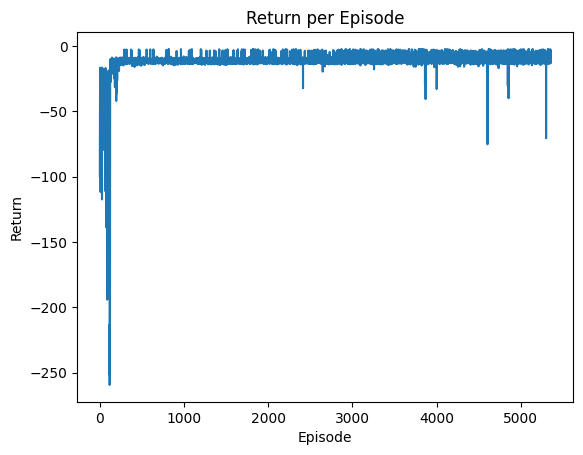

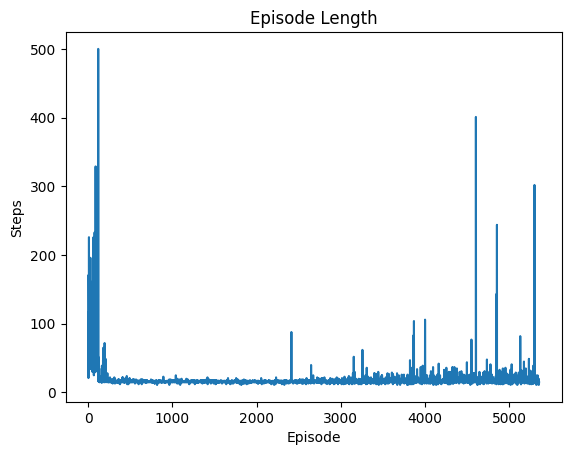

In [6]:
import matplotlib.pyplot as plt

# Reward per episode
plt.figure()
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Return per Episode")
plt.show()

# Duration per episode
plt.figure()
plt.plot(episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Episode Length")
plt.show()

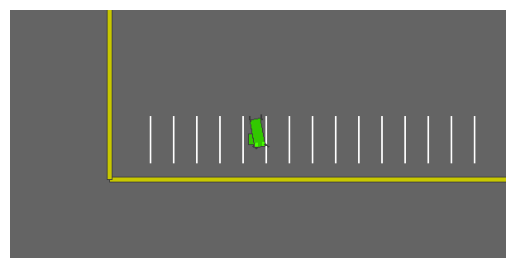

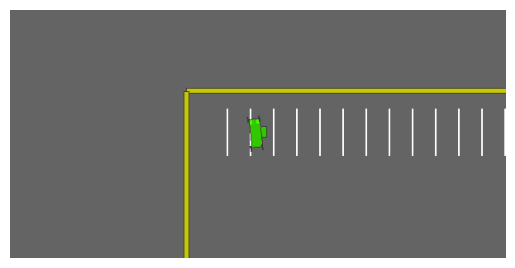

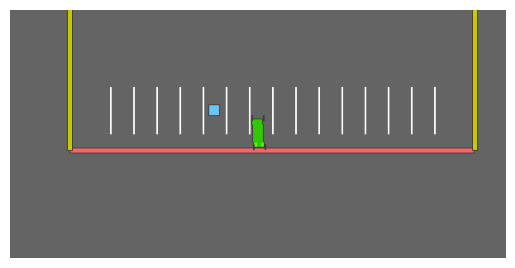

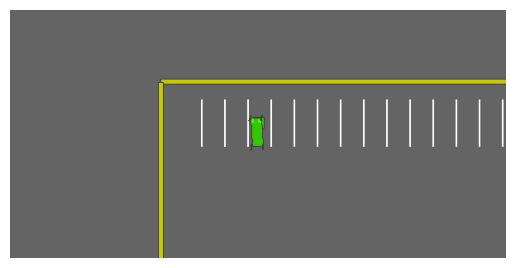

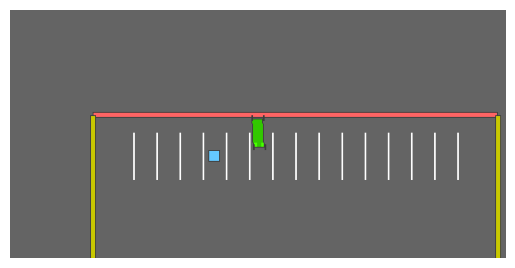

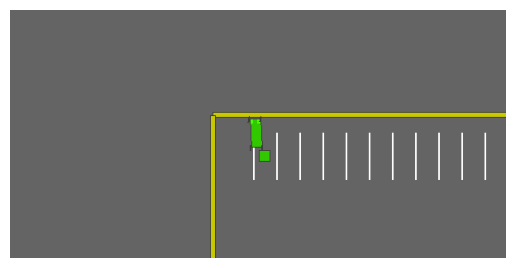

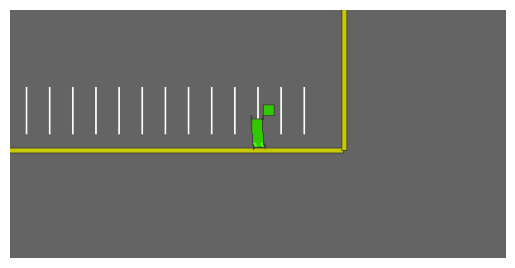

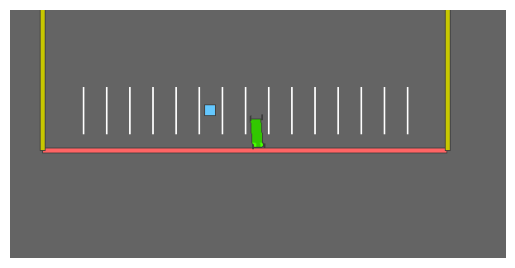

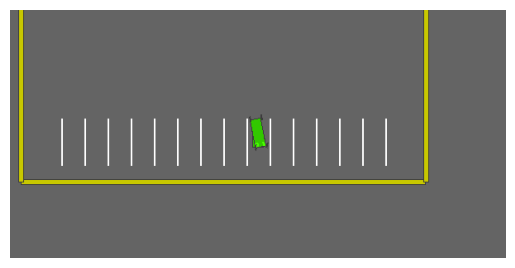

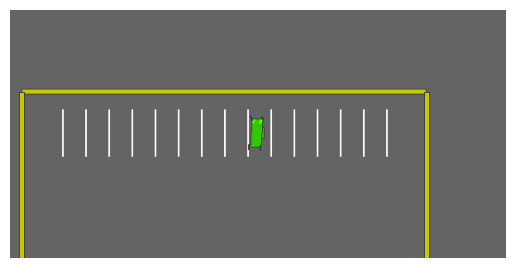

: 

In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def create_animation(frames, interval_ms=150):  # larger value = slower animation
    fig = plt.figure()
    im = plt.imshow(frames[0])
    plt.axis("off")

    def update(frame_idx):
        im.set_data(frames[frame_idx])
        return [im]

    return animation.FuncAnimation(
        fig, update,
        frames=len(frames),
        interval=interval_ms,
        blit=True
    )

# Load trained model
model = SAC.load("models/sac_parking")

# Create a rendered environment
env = gym.make("parking-v0", render_mode="rgb_array")

# Parameters
num_episodes = 10
max_steps = 500

# Stores all animations
all_frames = []

for episode in range(num_episodes):
    obs, info = env.reset()
    frames = []
    done = False
    step = 0

    while not done and step < max_steps:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
        frame = env.render()
        frames.append(frame)
        step += 1

    all_frames.append(frames)

env.close()

# Create and display animations
animations = [create_animation(frames, interval_ms=150) for frames in all_frames]
display(*[HTML(anim.to_jshtml()) for anim in animations])